Epoch 0, Loss=0.6796
Epoch 400, Loss=0.0112
Epoch 800, Loss=0.0112
Epoch 1200, Loss=0.0112
Epoch 1600, Loss=0.0112


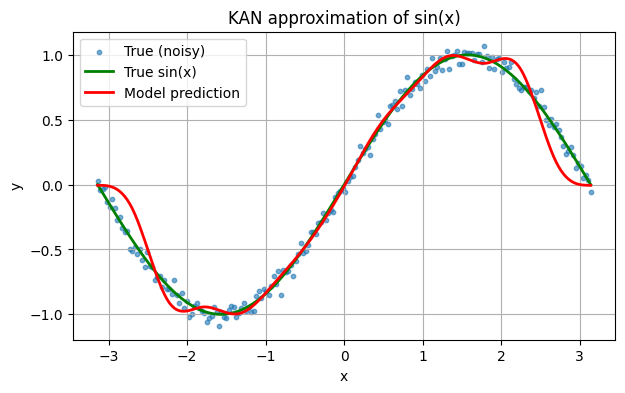

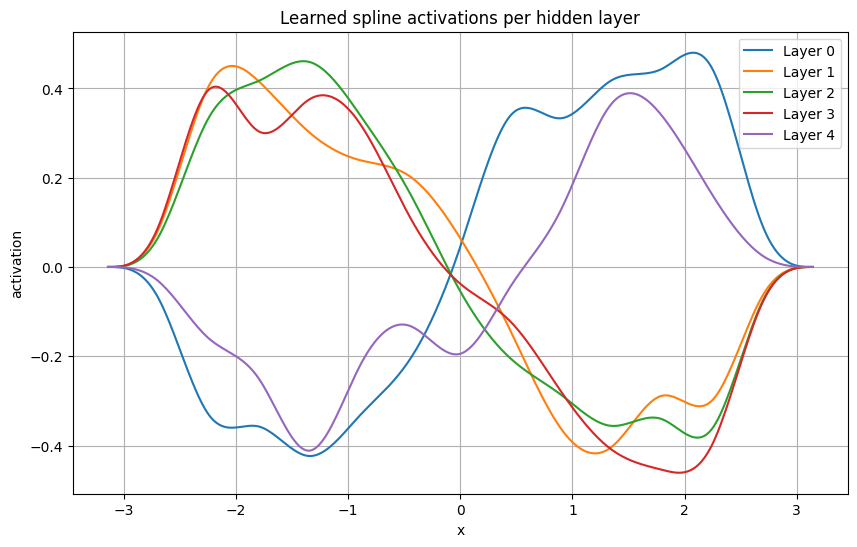

In [1]:
# File: ./kan_sine.py
# Purpose: Train KAN-inspired model on y=sin(x) regression task
#          and visualize learned spline activations.

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# -----------------------------
# B-spline activation function
# -----------------------------
class BSplineActivation(nn.Module):
    def __init__(self, input_dim, num_knots=15, degree=3, knot_min=-np.pi, knot_max=np.pi):
        """
        Per-feature B-spline activation with learned weights.
        """
        super().__init__()
        self.input_dim = input_dim
        self.degree = degree

        knots = np.linspace(knot_min, knot_max, num_knots).astype(np.float32)
        self.register_buffer("knots", torch.tensor(knots))

        self.num_basis = num_knots - degree - 1
        # one weight vector per feature
        self.weights = nn.Parameter(
            torch.randn(input_dim, self.num_basis) * 0.1)

    def forward(self, x):
        batch, D = x.shape
        out = torch.empty_like(x)
        for i in range(D):
            B = self._b_spline_matrix(x[:, i])
            out[:, i] = B @ self.weights[i]
        return out

    def _N(self, j, k, x, knots):
        """Cox–de Boor recursion."""
        if k == 0:
            return ((x >= knots[j]) & (x < knots[j + 1])).float()
        denom1 = knots[j + k] - knots[j]
        denom2 = knots[j + k + 1] - knots[j + 1]
        term1, term2 = 0, 0
        if denom1.item() != 0:
            term1 = ((x - knots[j]) / denom1) * self._N(j, k - 1, x, knots)
        if denom2.item() != 0:
            term2 = ((knots[j + k + 1] - x) / denom2) * \
                self._N(j + 1, k - 1, x, knots)
        return term1 + term2

    def _b_spline_matrix(self, x):
        n_intervals = self.knots.numel() - 1
        B = torch.zeros((x.shape[0], self.num_basis), device=x.device)
        for j in range(n_intervals - self.degree):
            B[:, j] = self._N(j, self.degree, x, self.knots)
        return B


# -----------------------------
# KAN-inspired model
# -----------------------------
class KAN(nn.Module):
    def __init__(self, input_dim, hidden_width, output_dim, num_knots=15, degree=3):
        super().__init__()
        self.hidden_layers = nn.ModuleList([
            BSplineActivation(input_dim, num_knots, degree, -np.pi, np.pi)
            for _ in range(hidden_width)
        ])
        self.output_layer = nn.Linear(hidden_width * input_dim, output_dim)

    def forward(self, x):
        h = torch.cat([layer(x) for layer in self.hidden_layers], dim=1)
        return self.output_layer(h)


# -----------------------------
# Training on sine function
# -----------------------------
def train_sine():
    # Generate mock dataset
    np.random.seed(42)
    torch.manual_seed(42)

    X = np.linspace(-np.pi, np.pi, 200).astype(np.float32)
    y = np.sin(X) + 0.05 * np.random.randn(*X.shape).astype(np.float32)

    X = torch.tensor(X).unsqueeze(1)  # (200,1)
    y = torch.tensor(y).unsqueeze(1)  # (200,1)

    # Model: 1 input → hidden_width B-spline modules → 1 output
    model = KAN(input_dim=1, hidden_width=5,
                output_dim=1, num_knots=15, degree=3)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(2000):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        if epoch % 400 == 0:
            print(f"Epoch {epoch}, Loss={loss.item():.4f}")

    # Predictions for visualization
    with torch.no_grad():
        y_fit = model(X)

    # Plot sine vs learned curve
    plt.figure(figsize=(7, 4))
    plt.scatter(X.numpy(), y.numpy(), label="True (noisy)", s=10, alpha=0.6)
    plt.plot(X.numpy(), np.sin(X.numpy()),
             label="True sin(x)", color="green", linewidth=2)
    plt.plot(X.numpy(), y_fit.numpy(),
             label="Model prediction", color="red", linewidth=2)
    plt.legend()
    plt.title("KAN approximation of sin(x)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

    # Plot learned activation functions from all hidden layers
    x_grid = torch.linspace(-np.pi, np.pi, 300).unsqueeze(1)
    plt.figure(figsize=(10, 6))
    for idx, layer in enumerate(model.hidden_layers):
        B = layer._b_spline_matrix(x_grid.squeeze(1))
        w = layer.weights[0]   # weights for the only input feature
        activation = B @ w
        plt.plot(x_grid.numpy(), activation.detach().numpy(),
                 label=f"Layer {idx}")
    plt.title("Learned spline activations per hidden layer")
    plt.xlabel("x")
    plt.ylabel("activation")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    train_sine()